In [1]:
import os
import re
import glob
import numpy as np
from fnmatch import fnmatch
import matplotlib.pyplot as plt

cwd = os.getcwd()
#plt.rcParams['text.usetex'] = True

# Notebook for comparison and validation of branch 327 vs. Sherpa v2

This notebook reads in results that are stored in the sub-folders of the git-repository. 

Below I define two function do this job, one for v2-type and one for v3-type output. They output the results as nested dictionaries, with the outer dictionary being the name of the run and the inner one the name of the value, e.g. `dict[<run name>][<value name>]`. 

Run names follow the following scheme: 
- LEP -- simplest setup, no PDFs
	
- LEP+1PDF -- as above, but PDF on one beam

- LEP+2PDF -- as above, but PDF on both beams
	
- LEP+2EPA -- LEP setup, but using EPA on both beams, no PDFs and process \texttt{22 22 -> 93 93}

- etc., analogous for HERA

Additionally, I'm running the LO_Z example from the CI and the Sherpa.LHC_Jets_MEPS.yaml example. 

The observables from the output are: 
- cross-section from integration (summed over all processes), "XS_int"

- error on the integration cross-section, "Err_int"

- cross-section from event generation, "XS_evg"

- error on the event generation cross-section, "Err_evg"

- Delta, as defined in the equation at the bottom, between integration and event generation

I also define functions to output the results as tables. 

In [2]:
def getResultsFromMyBranch():
    get_integration = re.compile(r": \033\[[0-9;]+m\033\[[0-9;]+m[0-9e\+\-\.]* pb\033\[[0-9;]+m \+\- \( \033\[[0-9;]+m[0-9e\+\-\.]* pb ")
    get_evtgen = re.compile(r"1m[ ]{1,}[0-9e\+\-\.]{4,}")
    splitter = re.compile(r"[0-9e\+\-\.]{4,}")
    results = {}
    filenames = glob.glob(cwd+"/my-branch/*.out",recursive=False)
    for filename in filenames:
        name = os.path.basename(filename)[:-4].replace("_","+")
        f = open(filename, 'r')
        int_matches = []
        evg_matches = []
        total_xs_int = 0
        total_err_int = 0
        for line in f:
            int_matches += get_integration.findall(line)
            evg_matches += get_evtgen.findall(line)
        if len(int_matches) not in {1,3,5,7,9,11} or len(evg_matches) != 2:
            print("Error: found too many results! Please check the file " + filename)
            print("Results for integration: " + str(len(int_matches)))
            print("Results for event generation: " + str(len(evg_matches)))
            continue
        for string in int_matches:
            xs, err = splitter.findall(string)
            total_xs_int += float(xs)
            total_err_int += float(err)**2
        results[name] = {}
        results[name]["XS_int"] = total_xs_int
        results[name]["Err_int"] = np.sqrt(total_err_int)
        results[name]["XS_evg"] = float(splitter.findall(evg_matches[0])[0])
        results[name]["Err_evg"] = float(splitter.findall(evg_matches[1])[0])
        results[name]["N_processes"] = int(len(int_matches))
        diff = results[name]['XS_int'] - results[name]['XS_evg']
        err = np.sqrt(results[name]['Err_int']**2 + results[name]['Err_evg']**2)
        results[name]["Delta"] = diff/err
        f.close()
    return results

def getResultsFromV2():
    get_integration = re.compile(r"[^I]\x1b\[0m : \033\[[0-9;]+m\033\[[0-9;]+m[0-9e\+\-\.]* pb\033\[[0-9;]+m \+\- \( \033\[[0-9;]+m[0-9e\+\-\.]* pb = ")
    get_evtgen = re.compile(r"Total XS\x1b\[0m is \x1b\[34m\x1b\[1m[0-9e\+\-\.]{4,} pb\x1b\[0m \+\- \( \x1b\[31m[0-9e\+\-\.]{4,} pb")
    splitter = re.compile(r"[0-9e\+\-\.]{4,}")
    results = {}
    filenames = glob.glob(cwd+"/v2.2.11/*.out",recursive=False)
    for filename in filenames:
        name = os.path.basename(filename)[:-4].replace("_","+")
        f = open(filename, 'r')
        int_matches = []
        evg_matches = []
        total_xs_int = 0
        total_err_int = 0
        for line in f:
            int_matches += get_integration.findall(line)
            evg_matches += get_evtgen.findall(line)
        if len(int_matches) not in {1,3,5,7,9,11} or len(evg_matches) != 1:
            print("Error: Please check the file " + filename)
            print("Results for integration: " + str(len(int_matches)))
            print("Results for event generation: " + str(len(evg_matches)))
            continue
        for string in int_matches:
            xs, err = splitter.findall(string)
            total_xs_int += float(xs)
            total_err_int += float(err)**2
        results[name] = {}
        results[name]["XS_int"] = total_xs_int
        results[name]["Err_int"] = np.sqrt(total_err_int)
        results[name]["XS_evg"] = float(splitter.findall(evg_matches[0])[0])
        results[name]["Err_evg"] = float(splitter.findall(evg_matches[0])[1])
        results[name]["N_processes"] = int(len(int_matches))
        diff = results[name]['XS_int'] - results[name]['XS_evg']
        err = np.sqrt(results[name]['Err_int']**2 + results[name]['Err_evg']**2)
        results[name]["Delta"] = diff/err
        f.close()
    return results

def printMDtable(results):
    print("| Run | Integration [pb] | Total XS [pb] | ratio | Diff/err")
    print("| --- | ---------------- | ------------- | ----- | -------- |")
    for run in results.keys():
        xsint = str("{:.4e}".format(results[run]['XS_int']))
        xsevg = str("{:.4e}".format(results[run]['XS_evg']))
        factor = str(round(results[run]['XS_int'] / results[run]['XS_evg'],3))
        delta = str(round(results[run]["Delta"], 3))
        line = "| " + run + " | " + xsint + " | " + xsevg + " | " + factor + " | " + delta + " |"
        print(line)
        
def printLatexTable(results):
    print("Run & Integration [pb] & Total XS [pb] & ratio & Diff/Err \\\\")
    print("\hline")
    for run in results.keys():
        xsint = str("{:.4e}".format(results[run]['XS_int']))
        xsevg = str("{:.4e}".format(results[run]['XS_evg']))
        factor = str(round(results[run]['XS_int'] / results[run]['XS_evg'],3))
        delta = str(round(results[run]["Delta"], 3))
        line = run + " & " + xsint + " & " + xsevg + " & " + factor + " & " + delta + " \\\\"
        print(line)

def printComparison(br, rel):
    print("Run & Branch 327 [pb] & Release 2.2.11 [pb] & ratio & Diff/Err \\\\")
    print("\hline")
    for run in rel.keys():
        xsrel = str("{:.4e}".format(rel[run]['XS_evg']))
        xsbr = str("{:.4e}".format(br[run]['XS_evg']))
        factor = str(round(float(xsbr) / float(xsrel),3))
        diff = rel[run]['XS_evg'] - br[run]['XS_evg']
        err = np.sqrt(rel[run]['Err_evg']**2 + br[run]['Err_evg']**2)
        line = run + " & " + xsbr + " & " + xsrel + " & " + factor + " & " + str(round(diff/err, 3)) + " \\\\"
        print(line)
        if(rel[run]["N_processes"] != br[run]["N_processes"]):
            print("Warning, number of processes does not coincide, N_v2 = " + str(rel[run]["N_processes"])
                 + ", N_v3 = " + str(br[run]["N_processes"]))

## Create the results via the above functions

It outputs if a read-out fails, which happens for HERA+EPA in v2: There a crash appears in the event generation. 

In [18]:
branch = getResultsFromMyBranch()
release = getResultsFromV2()

Error: Please check the file /Users/tstb64/sherpa-playground/validate-my-branch/v2.2.11/HERA_EPA.out
Results for integration: 3
Results for event generation: 0


## Print out the tables in MD and Latex format for the two version

### ...for branch 327

In [19]:
printMDtable(branch)
print()
printLatexTable(branch)

| Run | Integration [pb] | Total XS [pb] | ratio | Diff/err
| --- | ---------------- | ------------- | ----- | -------- |
| HERA+EPA | 3.9160e+03 | 3.9088e+03 | 1.002 | 0.645 |
| LO+Z | 1.9510e+03 | 1.9801e+03 | 0.985 | -0.524 |
| LEP+2EPA | 7.6191e+00 | 7.6303e+00 | 0.999 | -1.643 |
| LEP+2EPA+1PDF | 9.5618e-01 | 9.9146e-01 | 0.964 | -1.466 |
| HERA+EPA+PDF | 2.9174e+03 | 2.9439e+03 | 0.991 | -1.116 |
| LEP+1PDF | 5.0770e+01 | 5.0784e+01 | 1.0 | -0.21 |
| LEP+5Jets | 4.4293e+04 | 9.3366e+03 | 4.744 | 21.466 |
| HERA | 5.4188e+03 | 5.3463e+03 | 1.014 | 0.69 |
| LEP | 2.0825e+01 | 2.0827e+01 | 1.0 | -0.215 |
| LHC | 4.4666e+09 | 4.6849e+09 | 0.953 | -1.853 |
| LEP+2EPA+2PDF | 5.9825e-01 | 6.1502e-01 | 0.973 | -1.789 |
| LHC+Jets+MEPS | 5.2963e+08 | 5.3416e+08 | 0.992 | -0.767 |
| LEP+2PDF | 8.2070e+01 | 8.5377e+01 | 0.961 | -0.939 |
| HERA+PDF | 3.1863e+03 | 3.6002e+03 | 0.885 | -0.271 |

Run & Integration [pb] & Total XS [pb] & ratio & Diff/Err \\
\hline
HERA+EPA & 3.9160e+03 & 3.9088e

### ...and for version 2

In [20]:
printMDtable(release)
print()
printLatexTable(release)

| Run | Integration [pb] | Total XS [pb] | ratio | Diff/err
| --- | ---------------- | ------------- | ----- | -------- |
| LO+Z | 1.8930e+03 | 1.9469e+03 | 0.972 | -1.001 |
| LEP+2EPA | 7.7488e+00 | 7.6281e+00 | 1.016 | 9.126 |
| LEP+1PDF | 5.0397e+01 | 5.0383e+01 | 1.0 | 0.206 |
| HERA | 5.4511e+03 | 5.3194e+03 | 1.025 | 13.603 |
| LEP | 2.0826e+01 | 2.0819e+01 | 1.0 | 0.801 |
| LHC | 4.4214e+09 | 4.4466e+09 | 0.994 | -0.927 |
| LHC+Jets+MEPS | 5.6308e+08 | 5.5642e+08 | 1.012 | 1.048 |
| LEP+2PDF | 8.4576e+01 | 8.4976e+01 | 0.995 | -1.25 |
| HERA+PDF | 4.9815e+03 | 4.9294e+03 | 1.011 | 1.154 |

Run & Integration [pb] & Total XS [pb] & ratio & Diff/Err \\
\hline
LO+Z & 1.8930e+03 & 1.9469e+03 & 0.972 & -1.001 \\
LEP+2EPA & 7.7488e+00 & 7.6281e+00 & 1.016 & 9.126 \\
LEP+1PDF & 5.0397e+01 & 5.0383e+01 & 1.0 & 0.206 \\
HERA & 5.4511e+03 & 5.3194e+03 & 1.025 & 13.603 \\
LEP & 2.0826e+01 & 2.0819e+01 & 1.0 & 0.801 \\
LHC & 4.4214e+09 & 4.4466e+09 & 0.994 & -0.927 \\
LHC+Jets+MEPS & 5.6308e

## Comparison of the data between the two versions

Below I output a Latex table to compare the two runs. Note that not all runs did work on Sherpa v2, specifically the EPA+PDF runs. The last column is defined as $$ \Delta = ( \sigma_\text{release} - \sigma_\text{branch} ) / \sqrt{\delta_\text{release}^2 + \delta_\text{branch}^2} $$

Please also note that in the HERA_PDF run in Sherpa v2 the following error occurred, : 

```
Blob_List::FourMomentumConservation(): (0x1b07e28) Four Momentum is not conserved.
   p_{in} = (947.5,0,0,-892.5) vs. p_{out} = (947.5,0,0,-892.412),
   diff = (-1.13687e-13,0,0,0.0877121).
```

However, this accounts only to 1\% of the events. 

Note furthermore, that the EPA weight was changed in my branch, e.g. the two version can not actually be compared in that run. I will implement a switch to change the weight to the old version and validate that run. 

In [21]:
printComparison(branch, release)

Run & Branch 327 [pb] & Release 2.2.11 [pb] & ratio & Diff/Err \\
\hline
LO+Z & 1.9801e+03 & 1.9469e+03 & 1.017 & -0.43 \\
LEP+2EPA & 7.6303e+00 & 7.6281e+00 & 1.0 & -0.289 \\
LEP+1PDF & 5.0784e+01 & 5.0383e+01 & 1.008 & -4.504 \\
HERA & 5.3463e+03 & 5.3194e+03 & 1.005 & -0.255 \\
LEP & 2.0827e+01 & 2.0819e+01 & 1.0 & -0.873 \\
LHC & 4.6849e+09 & 4.4466e+09 & 1.054 & -2.0 \\
LHC+Jets+MEPS & 5.3416e+08 & 5.5642e+08 & 0.96 & 2.882 \\
LEP+2PDF & 8.5377e+01 & 8.4976e+01 & 1.005 & -0.117 \\
HERA+PDF & 3.6002e+03 & 4.9294e+03 & 0.73 & 0.984 \\


/var/folders/9p/7b6t78353s79n0wjc605b_740000gq/T/ipykernel_97141/1616504818.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


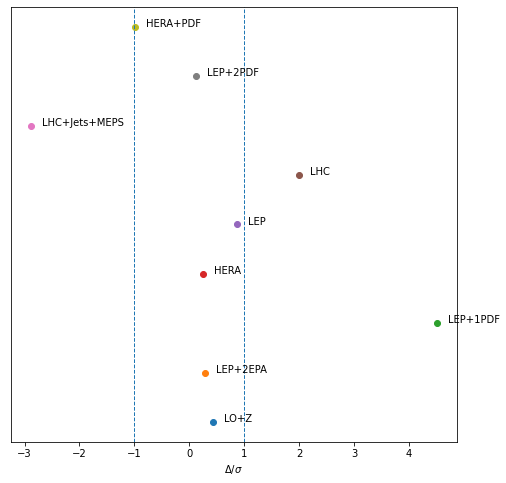

In [22]:
fig, ax = plt.subplots(figsize = (8,8))
i = 1
for run in release.keys():
        xsrel = str("{:.4e}".format(release[run]['XS_evg']))
        xsbr = str("{:.4e}".format(branch[run]['XS_evg']))
        diff = branch[run]['XS_evg'] - release[run]['XS_evg']
        err = np.sqrt(release[run]['Err_evg']**2 + branch[run]['Err_evg']**2)
        ax.plot(diff/err, i, 'o')
        ax.annotate(run, (diff/err+.2, i))
        i += 1
#plt.legend()
#plt.xlim(-5, 5)
#plt.xticks([-5, -3, -1, 0, 1, 3, 5])
ax.set_xlabel(r"$\Delta / \sigma$")
ax.set_yticks([])
ax.axvline(x=1, linestyle='--', linewidth=1)
ax.axvline(x=-1, linestyle='--', linewidth=1)
fig.show()
plt.savefig("results.png")